## Config

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

## Data

### Actual and TimeGPT forecats

In [16]:
df_train = pd.read_parquet('M3_yearly_processed_v2.parquet')
df_eval = pd.read_parquet('M3_yearly_simple_forecasts.parquet')

### Other methods used in competition

In [19]:
def read_all_sheets(excel_path):
    """
    Reads all sheets from an Excel file and combines them into a single DataFrame.
    
    Args:
    - excel_path (str): The path to the Excel file.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the combined data from all sheets.
    """
    # Use pandas to read the Excel file and get sheet names
    xls = pd.ExcelFile(excel_path)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        
        # Optionally, add a column to indicate the source sheet, if needed
        df['Sheet'] = sheet_name
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

excel_path = '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/M3Forecast.xls'
combined_df = read_all_sheets(excel_path)
# Rename columns
combined_df.rename(columns = {0 : 'Series', 1 : 'NF'}, inplace = True)

# Change series to int in the same fashion as the other dataframes
combined_df['Series'] = combined_df['Series'].str.replace('N', '')
combined_df['Series'] = combined_df['Series'].str.replace(' ', '')
combined_df['Series'] = combined_df['Series'].astype(int)
# Only yearly data for this evaluation
combined_df = combined_df.loc[combined_df['Series'] <= 645].copy()
# Drop not necessary columns
cols_to_drop = list(range(8, 19+1))
combined_df.drop(columns = cols_to_drop, inplace = True)

In [20]:
# Change position of sheet column
cols = combined_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
combined_df = combined_df[cols]

# Rename columns so that 1 is the first forecast period
combined_df.rename(columns=lambda x: x - 1 if isinstance(x, int) else x, inplace=True)

# Melt the dataframe i.e. unpivot
df_long = pd.melt(combined_df, id_vars=['Sheet', 'NF' , 'Series'], value_name='value', var_name='ForecastPeriod')   

# Sort the dataframe
df_long = df_long.sort_values(by=['Sheet', 'Series', 'ForecastPeriod']).copy()
df_long.head()

,Sheet,NF,Series,ForecastPeriod,value
7095,ARARMA,6,1,1,5553.26
21285,ARARMA,6,1,2,6246.45
35475,ARARMA,6,1,3,7026.18
49665,ARARMA,6,1,4,7903.23
63855,ARARMA,6,1,5,8889.77


## Official Evaluation Metrics
Five accuracy measures:
1. Symmetric MAPE

2. Average Ranking

3. Median symmetric APE

4. Median RAE

5. RMSE (root mean squared error)

Forecasting metrics calculations with assist of github repository:
https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

In [5]:
%run '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/forecasting_metrics.py'

#### NB! When using methods from this file nothing is multiplied with 100 for percentage operations!

In [6]:
actuals = np.array([900, 120, 138, 155, 149]) 
forecasts = np.array([1100, 124, 132, 141, 149]) 

### Symmetric MAPE (Mean Absolute Percentage Error)
The symmetric MAPE fluctuates between -200% and 200%

In [7]:
smape_val = smape(actuals, forecasts)
print(f'sMAPE: {smape_val * 100:.2f}%')

sMAPE: 7.44%


### Median Symmetric APE (median symmetric absolute percentage error)

In [8]:
symmetric_ape = smdape(actuals, forecasts)
print(f'sMAPE: {symmetric_ape * 100:.2f}%')

sMAPE: 4.44%


### Median RAE (relative absolute error)

In [9]:
mdrae_val = mdrae(actuals, forecasts)
print(f'MDRAE: {mdrae_val:.2f}')

MDRAE: 0.17


### RMSE (Root Mean Square Error)

In [10]:
rmse_val = rmse(actuals, forecasts)
print(f'RMSE: {rmse_val:.2f}')

RMSE: 89.72


## Evaluation

### First group all data together in one dataframe
Make sure it is correctly sorted! 

In [31]:
grouped_df = pd.merge(df_train, df_eval, on = ['Series', 'Date'], how = 'left')
grouped_df.dropna(subset = 'TimeGPT', inplace = True)
grouped_df.head()

,Series,N,NF,Category,Value,Date,TimeGPT
14,1,20,6,MICRO,5379.75,1989-01-01,5121.754395
15,1,20,6,MICRO,6158.68,1990-01-01,4974.531738
16,1,20,6,MICRO,6876.58,1991-01-01,4750.660156
17,1,20,6,MICRO,7851.91,1992-01-01,4366.261719
18,1,20,6,MICRO,8407.84,1993-01-01,3914.425781


In [32]:
# Add forecast period column to replace dates and prepare for merging
grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()

grouped_df.head(10)

<ipython-input-32-1e164491e749>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()


,Series,N,NF,Category,Value,Date,TimeGPT
0,1,20,6,MICRO,9156.01,1994-01-01,3427.987793
1,1,20,6,MICRO,8407.84,1993-01-01,3914.425781
2,1,20,6,MICRO,7851.91,1992-01-01,4366.261719
3,1,20,6,MICRO,6876.58,1991-01-01,4750.660156
4,1,20,6,MICRO,6158.68,1990-01-01,4974.531738
5,1,20,6,MICRO,5379.75,1989-01-01,5121.754395
6,2,20,6,MICRO,5209.60,1994-01-01,3442.831055
7,2,20,6,MICRO,5067.20,1993-01-01,3537.120605
8,2,20,6,MICRO,5056.00,1992-01-01,3656.133789
9,2,20,6,MICRO,5065.00,1991-01-01,3799.744629


In [33]:
### IMPORTANT ###
# Resort the dataframe to ensure correct evaluation
grouped_df = grouped_df.sort_values(by = ['Series', 'Date', 'Category']).copy()
grouped_df['ForecastPeriod'] = grouped_df.groupby('Series').cumcount() + 1
grouped_df.head(10)


,Series,N,NF,Category,Value,Date,TimeGPT,ForecastPeriod
5,1,20,6,MICRO,5379.75,1989-01-01,5121.754395,1
4,1,20,6,MICRO,6158.68,1990-01-01,4974.531738,2
3,1,20,6,MICRO,6876.58,1991-01-01,4750.660156,3
2,1,20,6,MICRO,7851.91,1992-01-01,4366.261719,4
1,1,20,6,MICRO,8407.84,1993-01-01,3914.425781,5
0,1,20,6,MICRO,9156.01,1994-01-01,3427.987793,6
11,2,20,6,MICRO,4793.20,1989-01-01,4093.745361,1
10,2,20,6,MICRO,5602.00,1990-01-01,3951.632812,2
9,2,20,6,MICRO,5065.00,1991-01-01,3799.744629,3
8,2,20,6,MICRO,5056.00,1992-01-01,3656.133789,4


In [47]:
final_df = pd.merge(grouped_df, df_long, on = ['Series', 'ForecastPeriod'], how = 'left')
# Drop not necessary columns
final_df.drop(columns = ['NF_x', 'N', 'NF_y', 'Date'], inplace = True)
final_df.rename(columns = {'Value' : 'Actual', 'value' : 'Forecast', 'Sheet' : 'Method'}, inplace = True)
final_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)
final_df.head(10)

,Series,Category,Actual,TimeGPT,ForecastPeriod,Method,Forecast
0,1,MICRO,5379.75,5121.754395,1,ARARMA,5553.26
1,1,MICRO,5379.75,5121.754395,1,Auto-ANN,5453.28
2,1,MICRO,5379.75,5121.754395,1,AutoBox1,5442.92
3,1,MICRO,5379.75,5121.754395,1,AutoBox2,4930.25
4,1,MICRO,5379.75,5121.754395,1,AutoBox3,5168.32
5,1,MICRO,5379.75,5121.754395,1,B-J auto,5486.10
6,1,MICRO,5379.75,5121.754395,1,COMB S-H-D,5272.43
7,1,MICRO,5379.75,5121.754395,1,DAMPEN,5473.87
8,1,MICRO,5379.75,5121.754395,1,Flors-Pearc1,5473.47
9,1,MICRO,5379.75,5121.754395,1,Flors-Pearc2,4852.81


In [52]:
timegpt_df = final_df.copy()
timegpt_df['Forecast'] = timegpt_df['TimeGPT']

# Step 2: Update the Method column
timegpt_df['Method'] = 'TimeGPT'

# Optional: If you want to remove original TimeGPT rows from the original df
# You might skip this step if you want to keep both Forecast and TimeGPT as separate methods
df = final_df.drop(columns=['TimeGPT'])

# Step 3: Concatenate the modified TimeGPT dataframe with the original dataframe
updated_df = pd.concat([df, timegpt_df])

updated_df.tail(10)

,Series,Category,Actual,ForecastPeriod,Method,Forecast,TimeGPT
85130,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85131,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85132,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85133,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85134,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85135,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85136,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85137,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85138,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043
85139,645,OTHER,4001.0,6,TimeGPT,6456.44043,6456.44043


In [53]:
updated_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)
updated_df.drop(columns = 'TimeGPT', inplace = True)
updated_df.drop_duplicates(inplace= True)
updated_df.head(30)

,Series,Category,Actual,ForecastPeriod,Method,Forecast
0,1,MICRO,5379.75,1,ARARMA,5553.260000
1,1,MICRO,5379.75,1,Auto-ANN,5453.280000
2,1,MICRO,5379.75,1,AutoBox1,5442.920000
3,1,MICRO,5379.75,1,AutoBox2,4930.250000
4,1,MICRO,5379.75,1,AutoBox3,5168.320000
5,1,MICRO,5379.75,1,B-J auto,5486.100000
6,1,MICRO,5379.75,1,COMB S-H-D,5272.430000
7,1,MICRO,5379.75,1,DAMPEN,5473.870000
8,1,MICRO,5379.75,1,Flors-Pearc1,5473.470000
9,1,MICRO,5379.75,1,Flors-Pearc2,4852.810000


In [59]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89010 entries, 0 to 85118
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series          89010 non-null  int64  
 1   Category        89010 non-null  object 
 2   Actual          89010 non-null  float64
 3   ForecastPeriod  89010 non-null  object 
 4   Method          89010 non-null  object 
 5   Forecast        89010 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ MB


### Agregated

In [83]:
def smape(a, f):
    """
    Calculate the symmetric mean absolute percentage error (sMAPE).
    Args:
    - a (np.array): An array of actual values.
    - f (np.array): An array of forecast values.
    """
    a = np.array(a)
    f = np.array(f)
    return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

results = []

# Adjusting to group by 'Series', 'Category', 'Method', and 'ForecastPeriod'
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    smape_value = smape(group['Actual'], group['Forecast'])
    
    results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'sMAPE': smape_value
    })

results_df = pd.DataFrame(results)


In [76]:
results_df.reset_index(inplace = True, drop = True)

,Series,Category,Method,ForecastPeriod,sMAPE
0,1,MICRO,ARARMA,1,3.174057
1,1,MICRO,ARARMA,2,1.415060
2,1,MICRO,ARARMA,3,2.152091
3,1,MICRO,ARARMA,4,0.651470
4,1,MICRO,ARARMA,5,5.572215
5,1,MICRO,ARARMA,6,8.806262
6,1,MICRO,Auto-ANN,1,1.357515
7,1,MICRO,Auto-ANN,2,2.552012
8,1,MICRO,Auto-ANN,3,4.287568
9,1,MICRO,Auto-ANN,4,8.568486


In [77]:
print(results_df.loc[(results_df['Method'] == 'ARARMA') &
                     (results_df['ForecastPeriod'] == 6)]['sMAPE'].mean())
### Works! ###

25.703171107842614


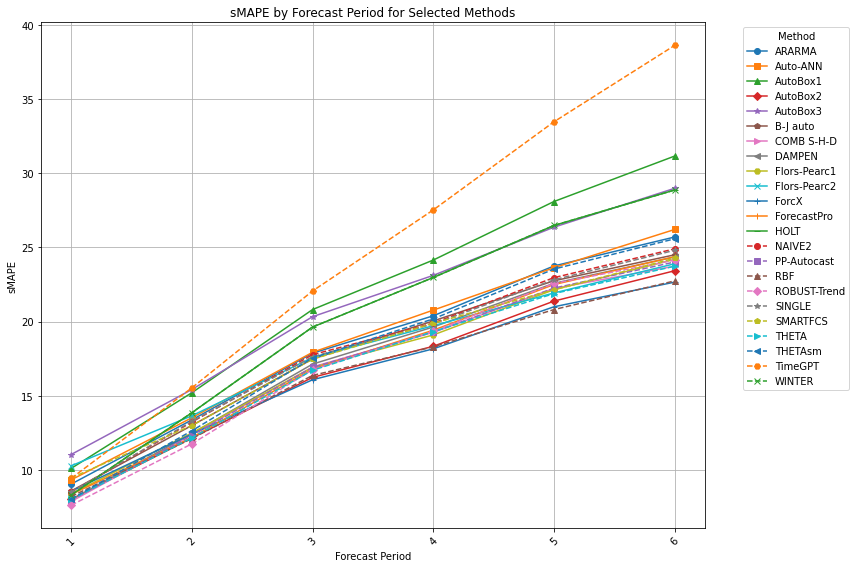

In [82]:
methods = results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['sMAPE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='sMAPE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('sMAPE')
plt.title('sMAPE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


TimeGPT clearly the worst in terms of sMAPE for first evaluation when there is no finetuning, will be promising to review with finetuning

#### Function that returns all eval metrics specified in competition

In [87]:
## Benchmark method, i.e. the naive method
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89010 entries, 0 to 85118
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series          89010 non-null  int64  
 1   Category        89010 non-null  object 
 2   Actual          89010 non-null  float64
 3   ForecastPeriod  89010 non-null  object 
 4   Method          89010 non-null  object 
 5   Forecast        89010 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ MB


In [88]:
benchmark = updated_df.loc[updated_df['Method'] == 'TimeGPT'].copy()
benchmark.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3870 entries, 0 to 85118
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series          3870 non-null   int64  
 1   Category        3870 non-null   object 
 2   Actual          3870 non-null   float64
 3   ForecastPeriod  3870 non-null   object 
 4   Method          3870 non-null   object 
 5   Forecast        3870 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 211.6+ KB


In [89]:
benchmark

,Series,Category,Actual,ForecastPeriod,Method,Forecast
0,1,MICRO,5379.75,1,TimeGPT,5121.754395
22,1,MICRO,6158.68,2,TimeGPT,4974.531738
44,1,MICRO,6876.58,3,TimeGPT,4750.660156
66,1,MICRO,7851.91,4,TimeGPT,4366.261719
88,1,MICRO,8407.84,5,TimeGPT,3914.425781
...,...,...,...,...,...,...
85030,645,OTHER,7343.00,2,TimeGPT,5939.305664
85052,645,OTHER,5730.00,3,TimeGPT,7121.730469
85074,645,OTHER,5007.00,4,TimeGPT,6801.107422
85096,645,OTHER,4715.00,5,TimeGPT,6733.273926


In [85]:
# Adjusting to group by 'Series', 'Category', 'Method', and 'ForecastPeriod'
full_results = []
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    smape_value = smape(group['Actual'], group['Forecast'])
    smdape_val = smdape(group['Actual'], group['Forecast'])
    mdrae_val = mdrae(group['Actual'], group['Forecast'])
    rmse_val = rmse(group['Actual'], group['Forecast'])

    full_results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'sMAPE': smape_value,
        'sMDAPE': smdape_val,
        'MDRAE': mdrae_val,
        'RMSE': rmse_val
    })

full_results_df = pd.DataFrame(full_results)

full_results_df.reset_index(inplace = True, drop = True)


/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tomaltenborg/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [86]:
full_results_df.head(10)

,Series,Category,Method,ForecastPeriod,sMAPE,sMDAPE,MDRAE,RMSE
0,1,MICRO,ARARMA,1,3.174057,0.031741,NaN,173.51
1,1,MICRO,ARARMA,2,1.415060,0.014151,NaN,87.77
2,1,MICRO,ARARMA,3,2.152091,0.021521,NaN,149.60
3,1,MICRO,ARARMA,4,0.651470,0.006515,NaN,51.32
4,1,MICRO,ARARMA,5,5.572215,0.055722,NaN,481.93
5,1,MICRO,ARARMA,6,8.806262,0.088063,NaN,843.44
6,1,MICRO,Auto-ANN,1,1.357515,0.013575,NaN,73.53
7,1,MICRO,Auto-ANN,2,2.552012,0.025520,NaN,155.19
8,1,MICRO,Auto-ANN,3,4.287568,0.042876,NaN,288.65
9,1,MICRO,Auto-ANN,4,8.568486,0.085685,NaN,645.15


### Not sure about this one have to go over!!

In [90]:
def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))

def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray):
    """Relative Error"""
    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)

def _error(actual: np.ndarray, forecast: np.ndarray):
    return actual - forecast

# Adjust the loop to include benchmark values in the calculation
full_results = []
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    # Retrieve the corresponding benchmark forecast for this group
    benchmark_group = benchmark[(benchmark['Series'] == series) & (benchmark['ForecastPeriod'] == period)]
    if not benchmark_group.empty:
        benchmark_forecast = benchmark_group['Forecast'].values
    else:
        # Handle missing benchmarks if necessary
        benchmark_forecast = np.array([np.nan] * len(group))
    
    # Calculate MDRAE using the benchmark forecast
    mdrae_val = mdrae(group['Actual'].values, group['Forecast'].values, benchmark_forecast)
    
    # Other calculations...

    full_results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'MDRAE': mdrae_val,
        # Include other metrics as needed
    })

full_results_df = pd.DataFrame(full_results)


In [91]:
full_results_df

,Series,Category,Method,ForecastPeriod,MDRAE
0,1,MICRO,ARARMA,1,0.672531
1,1,MICRO,ARARMA,2,0.074121
2,1,MICRO,ARARMA,3,0.070370
3,1,MICRO,ARARMA,4,0.014723
4,1,MICRO,ARARMA,5,0.107253
...,...,...,...,...,...
89005,645,OTHER,WINTER,2,0.649885
89006,645,OTHER,WINTER,3,0.511694
89007,645,OTHER,WINTER,4,0.806267
89008,645,OTHER,WINTER,5,0.867033
